In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa
import sklearn
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
plt.style.use("seaborn-v0_8")
import os
import soundfile as sf

2025-06-10 18:23:42.145700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749579822.203898   41725 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749579822.224310   41725 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
fn_csv = '/kaggle/input/scenes-stereo/scenes_stereo/dcase2013_task1_filenamekey.csv'
df = pd.read_csv(fn_csv)
files = []
labels = []
files = df['decodedname']
labels = df['label']
print(len(files))
print(len(labels))
audio_path = '/kaggle/input/scenes-stereo/scenes_stereo/scenes_stereo/'

200
200


In [3]:
from sklearn.preprocessing import LabelEncoder
unique_labels = labels.unique()
print(unique_labels)
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(unique_labels)
print(encoded_labels)
sorted_labels = [label for _, label in sorted(zip(encoded_labels, unique_labels))]
print(sorted_labels)

['office' 'tube' 'restaurant' 'busystreet' 'bus' 'supermarket'
 'openairmarket' 'park' 'quietstreet' 'tubestation']
[2 8 6 1 0 7 3 4 5 9]
['bus', 'busystreet', 'office', 'openairmarket', 'park', 'quietstreet', 'restaurant', 'supermarket', 'tube', 'tubestation']


In [4]:
files_train, files_test, labels_train, labels_test = train_test_split(files, labels, test_size=50, random_state=42, shuffle=True,stratify=labels)
# specificando il random_state ad ogni run ci sarà sempre lo stesso split (riproducibilità)

print(len(files_train))  # 150
print(len(files_test))   # 50
print(len(labels_train))  # 150
print(len(labels_test))   # 50

from collections import Counter
print("Train set class counts:")
print(Counter(labels_train))

print("Test set class counts:")
print(Counter(labels_test))

150
50
150
50
Train set class counts:
Counter({'tube': 15, 'office': 15, 'busystreet': 15, 'openairmarket': 15, 'park': 15, 'restaurant': 15, 'bus': 15, 'tubestation': 15, 'quietstreet': 15, 'supermarket': 15})
Test set class counts:
Counter({'quietstreet': 5, 'restaurant': 5, 'openairmarket': 5, 'tubestation': 5, 'bus': 5, 'office': 5, 'supermarket': 5, 'busystreet': 5, 'tube': 5, 'park': 5})


In [5]:
import librosa

augmented_data = []
fast_files = []
slow_files = []

for i, file in enumerate(files_train):
    signal, sr = librosa.load(audio_path + file)
    label = labels_train.iloc[i]
    base_name = os.path.splitext(file)[0]  # es: 'bus12.wav' → 'bus12'

    # Aggiungi il segnale originale
    augmented_data.append((signal, label, f"{base_name}_orig.wav"))

    # Crea versioni augmentate
    versions = {
        #'stretch_fast': librosa.effects.time_stretch(signal, rate=1.2), # da levare, peggiorano l'accuracy
        #'stretch_slow': librosa.effects.time_stretch(signal, rate=0.8), # idem
        'pitch_up': librosa.effects.pitch_shift(signal, sr=sr, n_steps=2),
        'pitch_down': librosa.effects.pitch_shift(signal, sr=sr, n_steps=-2)
    }

    # Aggiungi i segnali augmentati alla lista
    for suffix, aug_signal in versions.items():
        filename = f"{base_name}_{suffix}.wav"
        augmented_data.append((aug_signal, label, filename))
        if "stretch_fast" in suffix:
            fast_files.append(filename)
        elif "stretch_slow" in suffix:
            slow_files.append(filename)

In [6]:
print(len(fast_files))
print(len(slow_files))

0
0


In [7]:
fs = 22050 # solo per assicurarsi che altre funzioni non la cambino

In [8]:
import os
import soundfile as sf
import shutil

augmented_path = 'scenes_stereo_augmented/'

# Cancella e ricrea la cartella
#if os.path.exists(augmented_path):
#    shutil.rmtree(augmented_path)
#os.makedirs(augmented_path)

test_path = 'scenes_stereo_test/'
os.makedirs(augmented_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)


files_train_aug = []
labels_train_aug = []

for i, (signal, label, filename) in enumerate(augmented_data):
    filepath = os.path.join(augmented_path, filename)
    if filename in fast_files:
        signal_resampled = librosa.resample(signal, orig_sr=fs, target_sr=int(fs*1.2))
        augmented_data[i] = (signal_resampled, label, filename)
        sf.write(filepath, signal_resampled, int(fs*1.2))
    elif filename in slow_files:
        signal_resampled = librosa.resample(signal, orig_sr=fs, target_sr=int(fs*0.8))
        augmented_data[i] = (signal_resampled, label, filename)
        sf.write(filepath, signal_resampled, int(fs*0.8))
    else:
        sf.write(filepath, signal, fs)

    files_train_aug.append(filename)
    labels_train_aug.append(label)

# ho resamplato i file stretchati in modo che avessero lo stesso numero di campioni degli altri

In [9]:
print(len(files_train_aug))
print(len(files_test))
print(len(labels_train_aug))
print(len(labels_test))

450
50
450
50


In [10]:
sample_lengths = [len(signal) for signal, _, _ in augmented_data]
unique_lengths = set(sample_lengths)
print(f"Unique sample lengths: {unique_lengths}")


Unique sample lengths: {661500}


In [11]:
signals_fs = [librosa.load(audio_path + file) for file in files_test]
X_test = [s[0] for s in signals_fs]
print(len(X_test))
y_test = labels_test
print(len(y_test))

# test è ok, con X_test (segnali) e y_test (label)

50
50


In [12]:
X_train = [s for s, l, f in augmented_data]
y_train = [l for s, l, f in augmented_data]

In [13]:
print(len(X_train))
print(len(y_train))

# train è ok, con X_train (segnali) e y_train (label)

450
450


In [14]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# (750, 661500)
# (750, )
# (50, 661500)
# (50, )

(450, 661500)
(450,)
(50, 661500)
(50,)


In [16]:
'''
fs = 22050 # non fa mai male ridichiararla
time_axis = np.arange(len(signals[0]))/fs
'''

'\nfs = 22050 # non fa mai male ridichiararla\ntime_axis = np.arange(len(signals[0]))/fs\n'

In [17]:
'''

for i in range(50):
    plt.figure(figsize = (10, 5))
    plt.xlabel('time (s)')
    plt.plot(time_axis, X_test[i])
    plt.show()
    print(y_test[i])

'''

"\n\nfor i in range(50):\n    plt.figure(figsize = (10, 5))\n    plt.xlabel('time (s)')\n    plt.plot(time_axis, X_test[i])\n    plt.show()\n    print(y_test[i])\n\n"

In [18]:
w = 512
h = 256
n = 2048

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
def feature_extraction(x, fs, n, h):
    zcr = librosa.feature.zero_crossing_rate(x, hop_length = h)
    mean_zcr = np.mean(zcr)
    std_zcr = np.std(zcr)
    stft = np.abs(librosa.stft(x, n_fft=n, hop_length=h))**2
    melspec = (librosa.feature.melspectrogram(S=stft, n_mels=128))
    pcen_spec = librosa.pcen(melspec, sr=fs)
    melspec = librosa.power_to_db(melspec)
    mean_pcen = np.mean(pcen_spec)
    std_pcen = np.std(pcen_spec)
    delta_melspec = librosa.feature.delta(melspec)
    delta2_melspec = librosa.feature.delta(delta_melspec)
    mean_mel = np.mean(melspec)
    std_mel = np.std(melspec)
    mean_deltamel = np.mean(delta_melspec)
    std_deltamel = np.std(delta_melspec)
    mean_delta2mel = np.mean(delta2_melspec)
    std_delta2mel = np.std(delta2_melspec)
    C = np.abs(librosa.stft(x, n_fft = n, hop_length = h))
    S = librosa.amplitude_to_db(C, ref = np.max)
    spectral_flux = librosa.onset.onset_strength(S = S, sr = fs)
    mean_spectral_flux = np.mean(spectral_flux)
    std_spectral_flux = np.std(spectral_flux)
    spectral_contrast = librosa.feature.spectral_contrast(S=stft, sr=fs)
    mean_spectral_contrast = np.mean(spectral_contrast)
    std_spectral_contrast = np.std(spectral_contrast)
    tonnetz = librosa.feature.tonnetz(y=x, sr=fs)
    mean_tonnetz = np.mean(tonnetz)
    std_tonnetz = np.std(tonnetz)
    
    f_vector = np.concatenate(([mean_spectral_contrast, std_spectral_contrast], [mean_tonnetz, std_tonnetz], [mean_zcr, std_zcr], [mean_mel, std_mel], [mean_deltamel, std_deltamel], [mean_delta2mel, std_delta2mel], [mean_spectral_flux, std_spectral_flux], [mean_pcen, std_pcen]))
    return f_vector

In [21]:
f_vector_train = np.zeros((X_train.shape[0], 16))
f_vector_test = np.zeros((X_test.shape[0], 16))
# se aggiungete/togliete feature dal f_vector ricordatevi di cambiare la dimensione

for i in range(0, X_train.shape[0]):
    f_vector_train[i, :] = feature_extraction(X_train[i, :], fs = fs, n = n, h = h)
for i in range(0, X_test.shape[0]):
    f_vector_test[i, :] = feature_extraction(X_test[i, :], fs = fs, n = n, h = h)

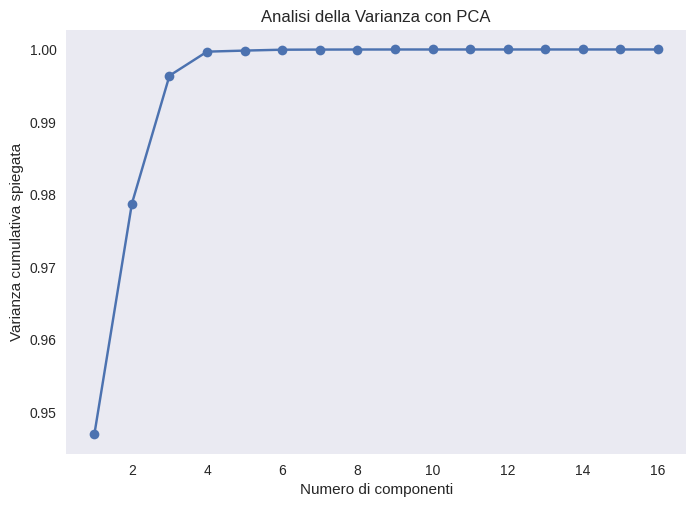

In [22]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(f_vector_train)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o")
plt.xlabel("Numero di componenti")
plt.ylabel("Varianza cumulativa spiegata")
plt.title("Analisi della Varianza con PCA")
plt.grid()
plt.show()

In [23]:
n_components = 4
pca = PCA(n_components=n_components)
pca.fit(f_vector_train)

# Creiamo un dataframe per interpretare i pesi delle feature
feature_names = ["mean_zcr", "std_zcr", "mean_mel", "std_mel", "mean_deltamel", "std_deltamel",
                 "mean_delta2mel", "std_delta2mel", "mean_spectral_flux", "std_spectral_flux", "mean_mfcc", "std_mfcc", "feature_13", "feature_14", "feature_15", "feature_16"]

loadings = pd.DataFrame(pca.components_.T, index=feature_names, columns=[f"PC{i+1}" for i in range(n_components)])
print(loadings)

                         PC1       PC2       PC3       PC4
mean_zcr            0.104056 -0.162184  0.954244 -0.218241
std_zcr             0.008916 -0.114778  0.204127  0.970511
mean_mel            0.000017 -0.000611 -0.000538 -0.001221
std_mel             0.000783 -0.000179  0.004305 -0.010472
mean_deltamel       0.000488 -0.014151  0.002415  0.022562
std_deltamel        0.000198 -0.003661  0.003125  0.004714
mean_delta2mel      0.993218 -0.032120 -0.111157  0.010407
std_delta2mel       0.050890  0.978237  0.177948  0.077201
mean_spectral_flux  0.000024  0.000431 -0.000350 -0.000687
std_spectral_flux   0.002225 -0.023838  0.039818 -0.044908
mean_mfcc          -0.000003 -0.000011 -0.000056 -0.000078
std_mfcc            0.000444 -0.005117  0.007403 -0.009852
feature_13         -0.002564 -0.040467 -0.042456  0.007267
feature_14          0.001743 -0.005154  0.001199 -0.036927
feature_15          0.001417  0.001873 -0.002871  0.002070
feature_16          0.001837 -0.008134  0.015571 -0.0153

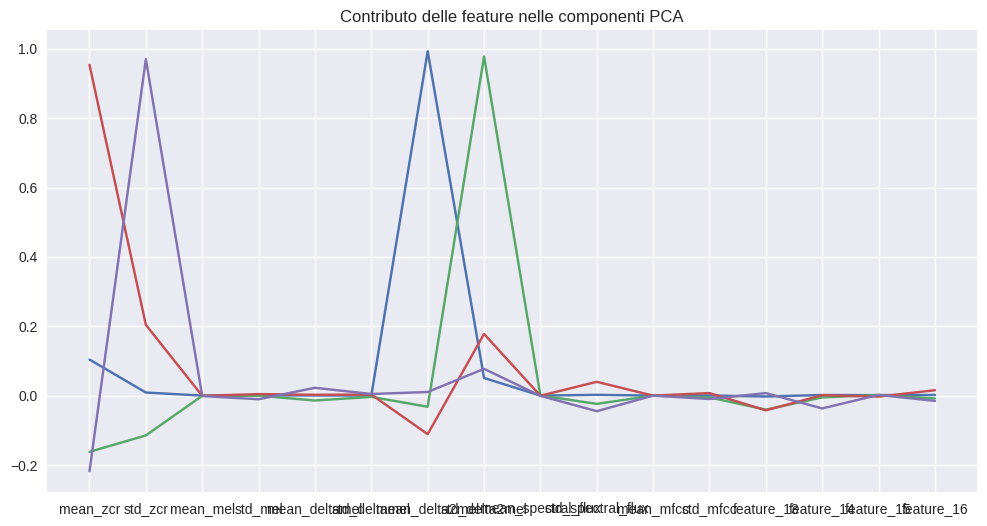

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(loadings)
plt.title("Contributo delle feature nelle componenti PCA")
plt.show()

In [25]:
'''

print(f_vector_train.shape)
print(f_vector_train[0, :])
print(f_vector_train[100, :])
plt.plot(f_vector_train[0, :])

'''

'\n\nprint(f_vector_train.shape)\nprint(f_vector_train[0, :])\nprint(f_vector_train[100, :])\nplt.plot(f_vector_train[0, :])\n\n'

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

mod = SVC(kernel = 'linear', C = 100)
mod.fit(f_vector_train, y_train)
train_pred = mod.predict(f_vector_train)
accuracy = accuracy_score(y_train, train_pred)
print('train: ', accuracy)
test_pred = mod.predict(f_vector_test)
accuracy = accuracy_score(y_test, test_pred)
print('test: ', accuracy)

# overfitta!! togliendo mfcc dal feature_vector migliora, però forse il problema è che abbiamo troppi dati di train perché prima con solo 150 andava meglio

train:  0.7933333333333333
test:  0.76


In [27]:
# aug: 450 (solo pitch), 10 feature (no mfcc), C = 10000

# acc train: 0.8
# acc test: 0.72

# con n = 2048 e h = 256, C = 100
# acc train: 0.7
# acc test: 0.74

               precision    recall  f1-score   support

          bus       0.98      0.91      0.94        45
   busystreet       0.80      0.98      0.88        45
       office       0.72      0.93      0.82        45
openairmarket       0.84      0.91      0.87        45
         park       0.61      0.51      0.55        45
  quietstreet       0.69      0.64      0.67        45
   restaurant       0.91      0.91      0.91        45
  supermarket       0.75      0.87      0.80        45
         tube       0.78      0.80      0.79        45
  tubestation       0.91      0.47      0.62        45

     accuracy                           0.79       450
    macro avg       0.80      0.79      0.79       450
 weighted avg       0.80      0.79      0.79       450



' \nmale:\nrecall di tubestation (falsi neg)\ntutto di park\n'

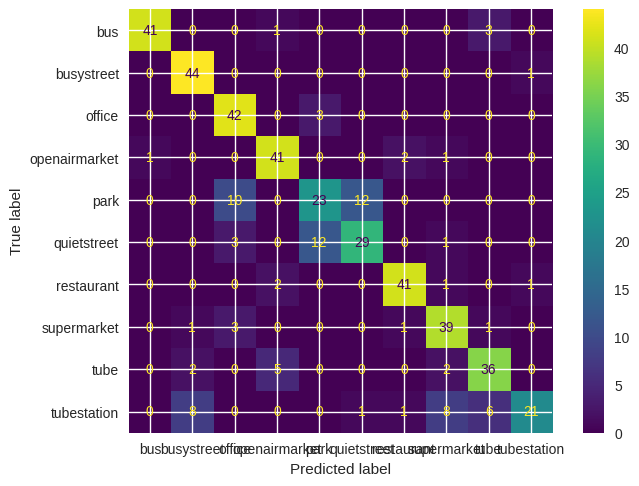

In [28]:
cm_train = confusion_matrix(y_train, train_pred)
(ConfusionMatrixDisplay(confusion_matrix = cm_train, display_labels = sorted_labels)).plot()

rep = classification_report(y_train, train_pred)
print(rep)

''' 
male:
recall di tubestation (falsi neg)
tutto di park
'''

               precision    recall  f1-score   support

          bus       1.00      0.80      0.89         5
   busystreet       0.62      1.00      0.77         5
       office       0.62      1.00      0.77         5
openairmarket       0.83      1.00      0.91         5
         park       1.00      0.40      0.57         5
  quietstreet       0.83      1.00      0.91         5
   restaurant       1.00      0.60      0.75         5
  supermarket       0.50      0.60      0.55         5
         tube       0.83      1.00      0.91         5
  tubestation       1.00      0.20      0.33         5

     accuracy                           0.76        50
    macro avg       0.82      0.76      0.74        50
 weighted avg       0.82      0.76      0.74        50



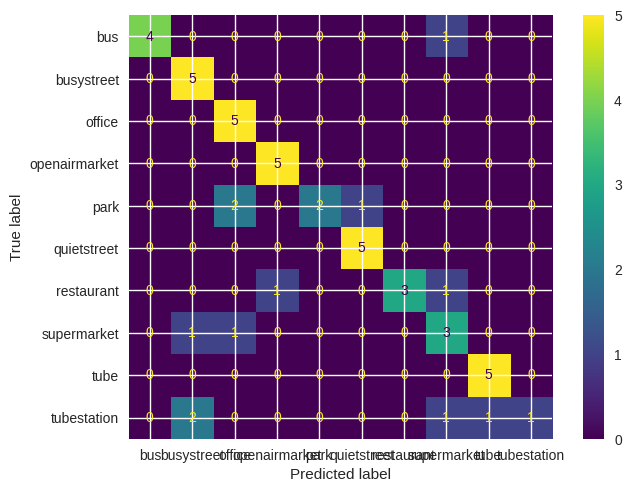

In [29]:
cm_test = confusion_matrix(y_test, test_pred)
(ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels = sorted_labels)).plot()

rep = classification_report(y_test, test_pred, zero_division = 0)
print(rep)

In [30]:
from sklearn.neighbors import KNeighborsClassifier

k = 10
knn = KNeighborsClassifier(n_neighbors=k)

# Allenare il modello
knn.fit(f_vector_train, y_train)

train_pred = knn.predict(f_vector_train)
accuracy = accuracy_score(y_train, train_pred)
print('train: ', accuracy)
test_pred = knn.predict(f_vector_test)
accuracy = accuracy_score(y_test, test_pred)
print('test: ', accuracy)

# decisamente no

train:  0.5155555555555555
test:  0.46


In [31]:
from pathlib import Path

signals = []
melspecs = []
base_path = Path('scenes_stereo_augmented/')

n_mels = 216
target_width = 1292
target_sr = 22050

temp_melspecs_db = [] # Lista temporanea per i melspecs in dB prima della normalizzazione

print(f"Inizio il calcolo, risampionamento e conversione in dB degli spettrogrammi Mel per il training set...")
for filename in files_train_aug:
    filepath = base_path / filename
    # Carica e riscampiona il segnale alla frequenza target (target_sr)
    signal, sr_actual = librosa.load(filepath, sr=target_sr) # <<< MODIFICA: sr=target_sr
    
    # Calcola lo spettrogramma Mel usando la frequenza target
    mel_spec = librosa.feature.melspectrogram(y=signal, sr=target_sr, n_mels=n_mels) # <<< MODIFICA: sr=target_sr
    
    # Applica il troncamento o padding per uniformare la larghezza temporale
    if mel_spec.shape[1] > target_width:
        mel_spec = mel_spec[:, :target_width]
    elif mel_spec.shape[1] < target_width:
        padding_needed = target_width - mel_spec.shape[1]
        mel_spec = np.pad(mel_spec, ((0, 0), (0, padding_needed)), mode='constant')

    # Converti in dB (QUESTO È IMPORTANTE!)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max) # <<< MODIFICA: Rimossa la commento
    temp_melspecs_db.append(mel_spec_db)
print(f"Calcolo e conversione in dB completati per il training set.")


# --- FASE 2: CALCOLO DEI VALORI DI NORMALIZZAZIONE GLOBALE E APPLICAZIONE ---
# Converti la lista temporanea in un array NumPy per trovare i valori min/max globali
temp_melspecs_array_db = np.array(temp_melspecs_db)

# Calcola il minimo e il massimo sull'intero array del training set
global_min_db = np.min(temp_melspecs_array_db)
global_max_db = np.max(temp_melspecs_array_db)

print(f"Valori globali per normalizzazione (Training Set): Min={global_min_db:.4f}, Max={global_max_db:.4f}")

# Ora, crea la lista finale 'melspecs' con gli spettrogrammi normalizzati globalmente
melspecs = []
for mel_spec_db_item in temp_melspecs_array_db:
    # Applica la normalizzazione usando i min/max globali calcolati sopra
    # Questo è fondamentale per la coerenza tra tutti i campioni
    # Evita divisione per zero se global_max_db == global_min_db
    if global_max_db - global_min_db == 0:
        mel_spec_normalized = np.zeros_like(mel_spec_db_item) # O gestisci l'errore diversamente
    else:
        mel_spec_normalized = (mel_spec_db_item - global_min_db) / (global_max_db - global_min_db)
    melspecs.append(mel_spec_normalized)

Inizio il calcolo, risampionamento e conversione in dB degli spettrogrammi Mel per il training set...
Calcolo e conversione in dB completati per il training set.
Valori globali per normalizzazione (Training Set): Min=-80.0000, Max=0.0000


In [32]:
Xdata = np.array(melspecs)  # shape: (N, n_mels, T)
Xdata = Xdata[..., np.newaxis]  # shape: (N, n_mels, T, 1)

print("Xdata shape (dopo Mel-spec, padding e normalizzazione globale):", Xdata.shape)

target_width = 1292
Xdata_cropped = Xdata
print("Xdata_cropped shape (dopo Mel-spec, padding e normalizzazione globale):", Xdata_cropped.shape)

from tensorflow.keras.utils import to_categorical

# Encoding delle label
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(labels_train_aug) # Fitta l'encoder sulle etichette di training
Ydata = to_categorical(y_encoded)  # Converte in One-Hot Encoding

print("Xdata shape_cropped:", Xdata_cropped.shape)  # es: (450, 216, 512, 1)
print("Ydata shape:", Ydata.shape)  # es: (750, 10)

# Define target shape
target_T = 1292  # this must match the cropped T from training
n_mels = 216     # this must match training too
fs = 22050

X_test_mel = []

for signal in X_test:
    mel_spec_test = librosa.feature.melspectrogram(y=signal, sr=fs, n_mels=n_mels)

    if mel_spec_test.shape[1] > target_width:
        mel_spec_test = mel_spec_test[:, :target_width]
    elif mel_spec_test.shape[1] < target_width:
        padding_needed_test = target_width - mel_spec_test.shape[1]
        mel_spec_test = np.pad(mel_spec_test, ((0, 0), (0, padding_needed_test)), mode='constant')
    
    mel_spec_db_test = librosa.power_to_db(mel_spec_test, ref=np.max)
    
    mel_spec_normalized_test = (mel_spec_db_test - global_min_db) / (global_max_db - global_min_db)
    if global_max_db - global_min_db == 0:
        mel_spec_normalized_test = np.zeros_like(mel_spec_db_test)
    else:
        mel_spec_normalized_test = (mel_spec_db_test - global_min_db) / (global_max_db - global_min_db)
    X_test_mel.append(mel_spec_normalized_test)

X_test_array = np.array(X_test_mel)[..., np.newaxis]  # shape: (N, 216, 512, 1) N should be 50
print("X_test_array shape:", X_test_array.shape)

#encoder = LabelEncoder()
y_test_encoded = encoder.transform(y_test)
Y_test = tf.keras.utils.to_categorical(y_test_encoded)  # shape: (N, 10)

print("Y_test shape:", Y_test.shape)

Xdata shape (dopo Mel-spec, padding e normalizzazione globale): (450, 216, 1292, 1)
Xdata_cropped shape (dopo Mel-spec, padding e normalizzazione globale): (450, 216, 1292, 1)
Xdata shape_cropped: (450, 216, 1292, 1)
Ydata shape: (450, 10)
X_test_array shape: (50, 216, 1292, 1)
Y_test shape: (50, 10)


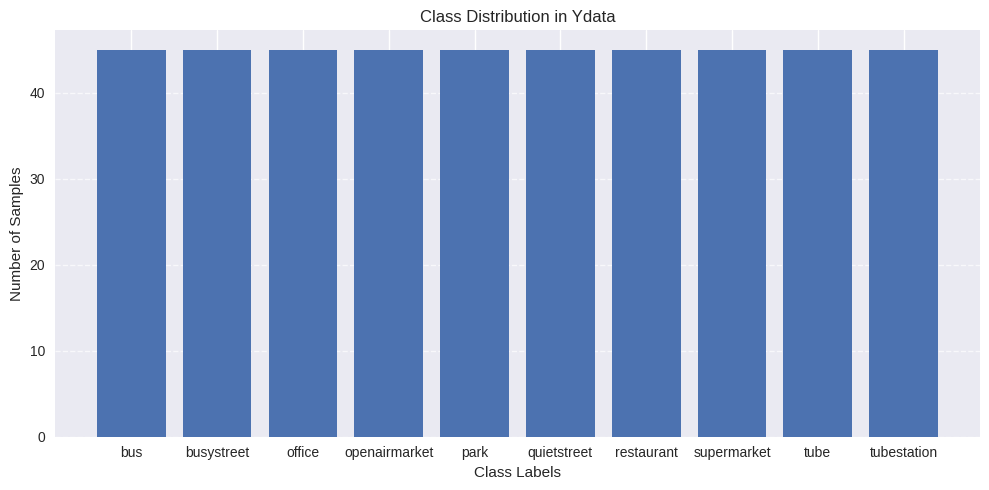

In [33]:
# Get the unique labels and their counts
#Check that Ydata is balanced by plotting the histogram.
unique_labels, counts = np.unique(labels_train_aug, return_counts=True)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.bar(unique_labels, counts)
plt.title("Class Distribution in Ydata")
plt.xlabel("Class Labels")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout,
    Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam

input_shape = (216, 1292, 1)   # Mel spectrogram shape

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2), padding='same'),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'), # <<< MODIFICA: Aumentato a 128 filtri
    MaxPooling2D((2, 2), padding='same'),
    BatchNormalization(),

    Conv2D(256, (3, 3), activation='relu', padding='same'), # <<< NUOVO STRATO
    MaxPooling2D((2, 2), padding='same'), # <<< NUOVO MAXPOOLING
    BatchNormalization(), # <<< NUOVA BATCHNORMALIZATION

    GlobalAveragePooling2D(), # <<< MODIFICA: Sostituzione di Flatten
    
    Dense(256, activation='relu'), # <<< MODIFICA: Aumentato a 256 neuroni
    Dropout(0.5), # <<< MODIFICA: Aumentato il dropout per maggiore regolarizzazione
    
    # Strato di output
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749580188.344294   41725 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749580188.344995   41725 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 216, 1292, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 108, 646, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 108, 646, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 108, 646, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 323, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 323, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 54, 323, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 27, 162, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 27, 162, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 162, 256)        │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 81, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 81, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 458,122 (1.75 MB)

 Trainable params: 457,162 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [35]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=500,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True
    )
]
history = model.fit(
    Xdata_cropped, Ydata,
    epochs=500,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/500


I0000 00:00:1749580194.877565   41800 service.cc:148] XLA service 0x7a586800f090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749580194.877621   41800 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749580194.877626   41800 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749580195.299998   41800 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749580212.611088   41800 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.0439 - loss: 2.4255 - val_accuracy: 0.1333 - val_loss: 2.2902
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.0920 - loss: 2.3452 - val_accuracy: 0.1556 - val_loss: 2.2794
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - accuracy: 0.1460 - loss: 2.2444 - val_accuracy: 0.1667 - val_loss: 2.2717
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accuracy: 0.2131 - loss: 2.1855 - val_accuracy: 0.1667 - val_loss: 2.2666
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accuracy: 0.2251 - loss: 2.1233 - val_accuracy: 0.1667 - val_loss: 2.2629
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - accuracy: 0.2696 - loss: 2.0637 - val_accuracy: 0.1667 - val_loss: 2.2605
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - accuracy: 0.3423 - loss: 2.0460 - val_accuracy: 0.1444 - val_loss: 2.2593
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - accuracy: 0.2786 - loss: 2.0549 - val_accuracy: 0.1333 -

In [36]:
loss, accuracy = model.evaluate(X_test_array, Y_test)
#print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")
#2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.2329 - loss: 2.0410 this is the best accuracy i could get

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7033 - loss: 1.0805  
Test accuracy: 0.6800


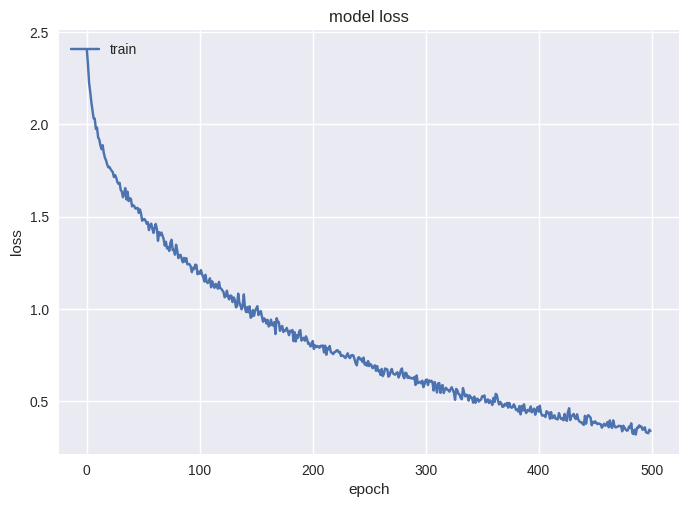

In [37]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

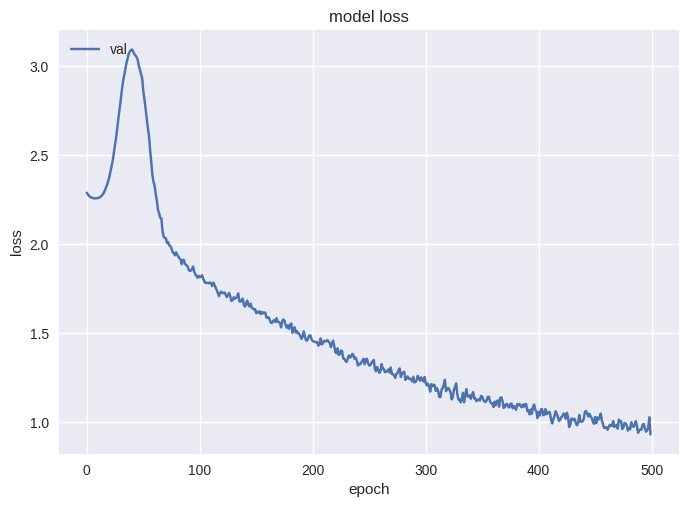

In [39]:
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend(['val'], loc='upper left')
plt.show()

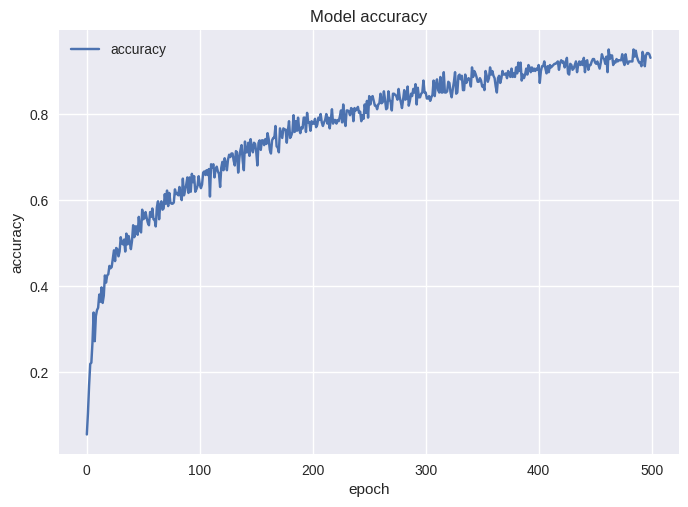

In [41]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper left')
plt.show()

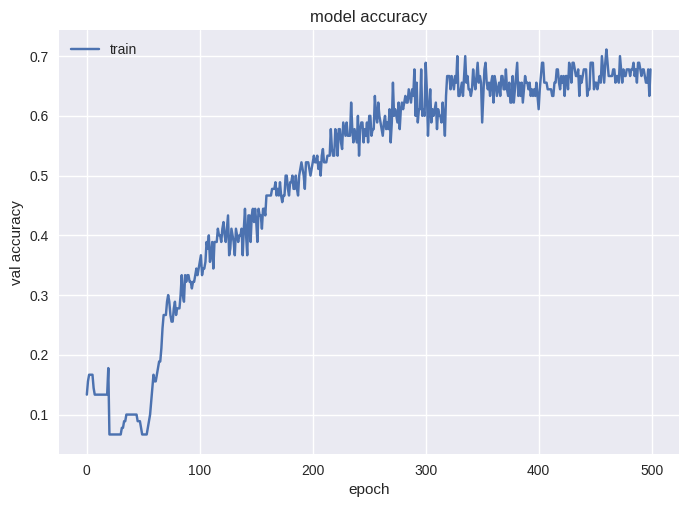

In [42]:
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()